In [1]:
from typing import Tuple, List
from collections import defaultdict
import numpy as np
import glob
import matplotlib.pyplot as plt

import librosa

from src.audio_process.process import AudioConverter
from src.net.reservoir import ESN_2D

/Users/oharasoh/reservoir/mic_input/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/oharasoh/reservoir/mic_input/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## データの読み込み

In [2]:
!ls data/cripped_wav

bass_001.wav    bass_005.wav    hi-hat_004.wav  k-snare_003.wav snare_004.wav
bass_002.wav    hi-hat_001.wav  hi-hat_005.wav  snare_001.wav   snare_005.wav
bass_003.wav    hi-hat_002.wav  k-snare_001.wav snare_002.wav
bass_004.wav    hi-hat_003.wav  k-snare_002.wav snare_003.wav


In [3]:
audio_paths = glob.glob("./data/cripped_wav/*.wav")

In [4]:
audio_data = []
for path in audio_paths:
    audio, sr = librosa.load(path, sr=8000)
    audio_type = path.split("/")[-1].split("_")[0]
    audio_data.append((audio, audio_type))

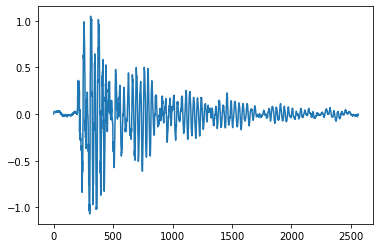

In [88]:
plt.plot(audio_data[9][0])

## 学習用のデータ生成器の作成

In [6]:
CHANNELS = 1
CHUNK = 2**6
RATE = 8000  # サンプリングレート
N_MELS = 32
OVERLAP_RATE = 0.0

CLASSES = {
    "bass": 0,
    "hi-hat": 1,
    "snare": 2,
    "k-snare": 2
}
N_CLASSES = 3

converter = AudioConverter(CHUNK, N_MELS, RATE)

In [7]:
max_length = 0
for audio, label in audio_data:
    if len(audio) > max_length:
        max_length = len(audio)
print(max_length)

2961


In [8]:
max_n_frame = (max_length - 1)// CHUNK + 1

In [9]:
# データを3次元のスペクトログラムにするのではなく、ながーい2次元のスペクトログラムにする
## こちらでは、テスト用のデータ
test_input_spectrograms = np.zeros([len(audio_data), max_n_frame, N_MELS])
test_input_spectrograms -= 9.
label_seqs = np.zeros([len(audio_data), max_n_frame, N_CLASSES])
for idx, (audio, label) in enumerate(audio_data):
    spectrogram = np.zeros([max_n_frame, N_MELS]) - 9
    n_frame = (len(audio) - 1) // CHUNK
    for i in range(max_n_frame):
        start = i * CHUNK
        end = (i + 1) * CHUNK
        if i == 0:
            spectrogram[i] = converter(audio[:end]).flatten()
        elif i < n_frame:
            spectrogram[i] = converter(audio[start:end]).flatten()
        elif i == n_frame:
            audio_part = np.concatenate([audio[start:], np.zeros(CHUNK - len(audio[start:]))], axis=0)
            spectrogram[i] = converter(audio_part).flatten()
    label_seqs[idx, :n_frame, CLASSES[label]] = 1
    test_input_spectrograms[idx] = spectrogram

/Users/oharasoh/reservoir/mic_input/src/audio_process/process.py:17: RuntimeWarning: divide by zero encountered in log10
  return np.log10(np.dot(self.mel_basis, data_fft.reshape(-1, 1)))


In [10]:
# make a long 2D spectrogram which can be dealt with as a large batch.
def make_train_dataset(audio_data: List[Tuple[np.array, str]]) -> Tuple[np.array, np.array]:
    """音声データ一覧から学習に使う用のデータを作成する

        Parameters
        ----------
        audio_data : List[Tuple]
            1 つ 1 つの要素は (audio:1d-array, label: str) となっている。
            入力となる音声信号データとそれにつけられたラベル('hi-hat','snare' など)
    
        Returns
        -------
        Tuple[np.array, np.array]
            全ての音声を結合した長いスペクトログラムとフレームごとのラベルを one-hot 形式に変換したもの
    """
    input_spectrogram_list = []
    label_seq_list = []

    for idx, (audio, label) in enumerate(audio_data):
        n_frame = (len(audio) - 1) // CHUNK
        for i in range(n_frame):
            start = i * CHUNK
            end = (i + 1) * CHUNK
            if i == 0:
                converted_audio = converter(audio[:end])  # (N_MELS, 1)
            else:
                converted_audio = converter(audio[start:end])  # (N_MELS, 1)
            input_spectrogram_list.append(converted_audio)
            label_seq_part = np.zeros([N_CLASSES, 1])
            label_seq_part[CLASSES[label], 0] = 1
            label_seq_list.append(label_seq_part)

    input_spectrogram = np.concatenate(input_spectrogram_list, axis=1)
    label_seq = np.concatenate(label_seq_list, axis=1)
    return (input_spectrogram, label_seq)

In [11]:
mel_freqs = converter.mel_freqs

音声のスペクトログラムの可視化

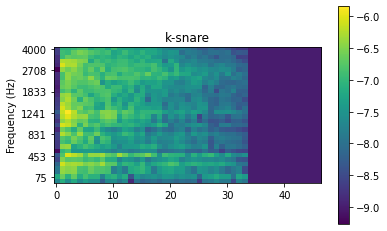

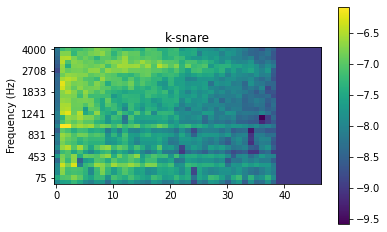

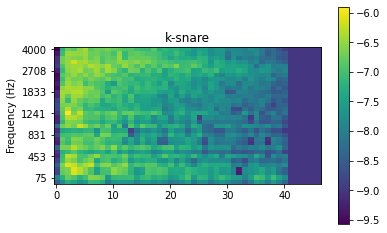

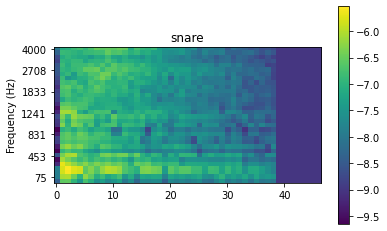

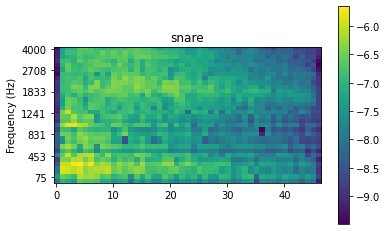

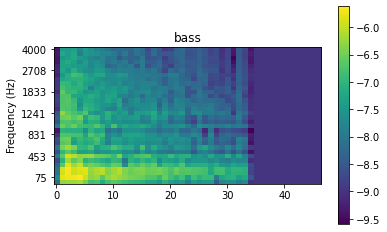

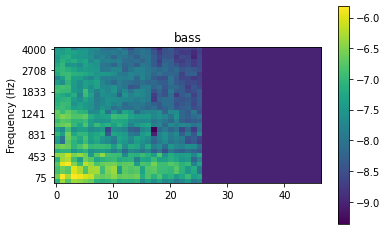

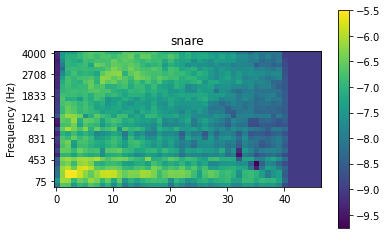

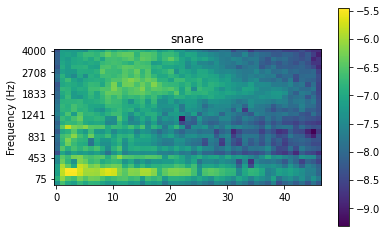

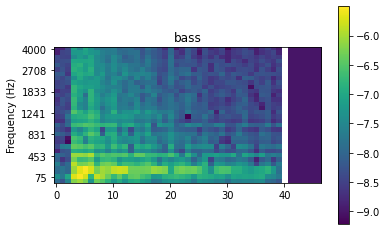

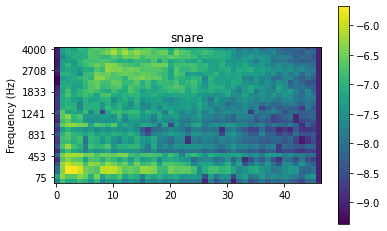

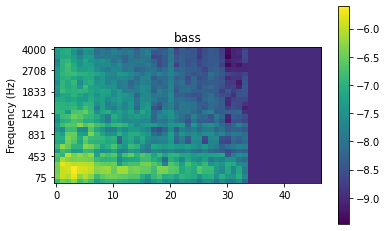

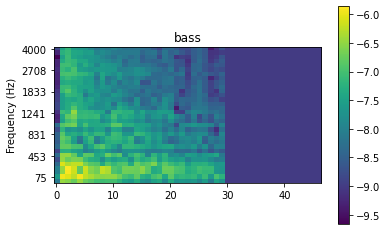

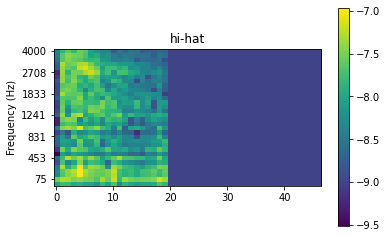

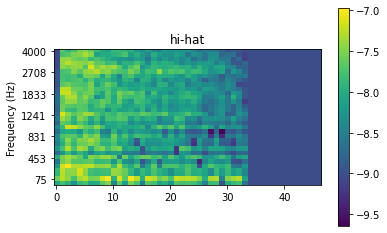

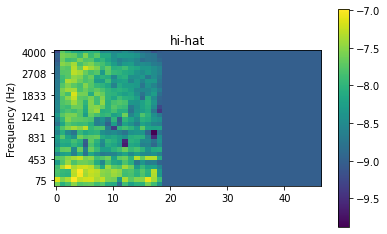

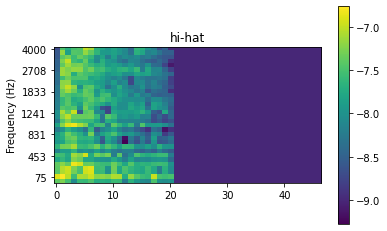

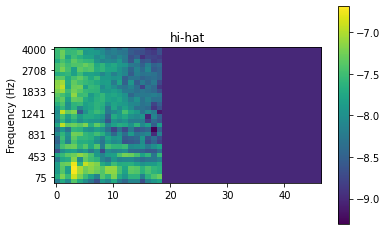

In [12]:
for idx, input_spectrogram in enumerate(test_input_spectrograms):
    fig = plt.figure()
    audio_ax = fig.add_subplot(1, 1, 1)
    picture = audio_ax.imshow(input_spectrogram.T[::-1])
    fig.colorbar(picture, ax=audio_ax)
    audio_ax.set_yticks(np.arange(0, N_MELS, 5))
    audio_ax.set_yticklabels([f"{int(f)}" for f in mel_freqs[::-5]])
    audio_ax.set_ylabel("Frequency (Hz)")
    audio_ax.set_aspect(0.75)
    audio_ax.set_title(audio_data[idx][1])

## ネットワークの学習

In [29]:
from sklearn.linear_model import Ridge

In [76]:
# まずはメタデータの入力
network_config = {
    "height": 20,
    "width": 20,
    "input_dim": N_MELS,
    "output_dim": N_CLASSES,
    "alpha": 0.70,  # 直前の state をどれだけ残すか
}

In [77]:
network = ESN_2D(**network_config)

In [78]:
valid_ratio = 0.2
num_data = len(audio_data)
shuffled_idx = np.random.permutation(num_data)

num_valid = int(num_data * valid_ratio)
valid_idxes = shuffled_idx[:num_valid]
train_idxes = shuffled_idx[num_valid:]


In [79]:
train_input_spectrogram, train_label_seq = make_train_dataset([audio_data[idx] for idx in train_idxes])
valid_input_spectrogram, valid_label_seq = make_train_dataset([audio_data[idx] for idx in valid_idxes])

In [80]:
regressor = Ridge()

In [81]:
train_state = np.zeros([train_input_spectrogram.shape[1], network.height * network.width])
for idx in range(train_input_spectrogram.shape[1]):
    network(train_input_spectrogram[:, idx])
    train_state[idx, :] = network.x_flatten

In [82]:
valid_state = np.zeros([valid_input_spectrogram.shape[1], network.height * network.width])
for idx in range(valid_input_spectrogram.shape[1]):
    network(valid_input_spectrogram[:, idx])
    valid_state[idx, :] = network.x_flatten

In [83]:
regressor.fit(train_state, train_label_seq.T)
train_score = regressor.score(train_state, train_label_seq.T)
valid_score = regressor.score(valid_state, valid_label_seq.T)

In [84]:
print("Score")
print(f"\t train: {train_score:.2f}")
print(f"\t valid: {valid_score:.2f}")

Score
	 train: 0.55
	 valid: -0.17


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

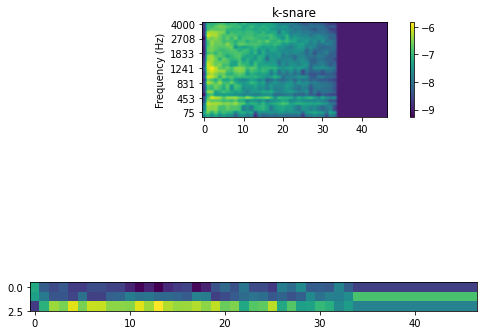

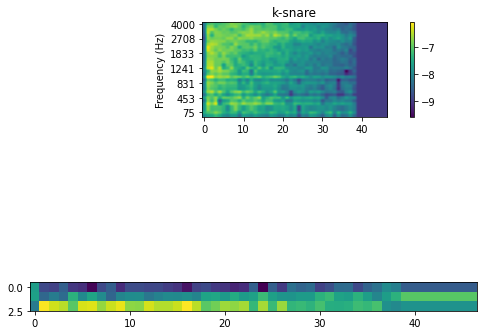

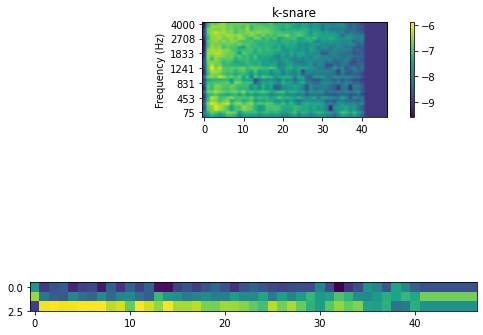

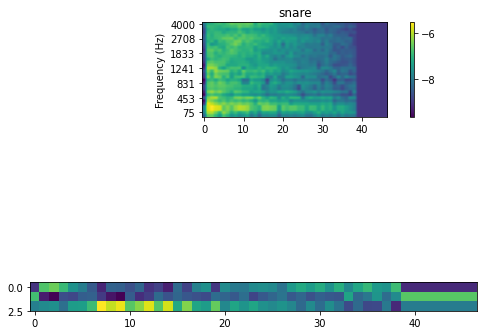

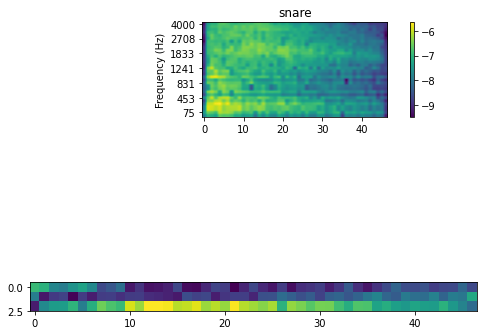

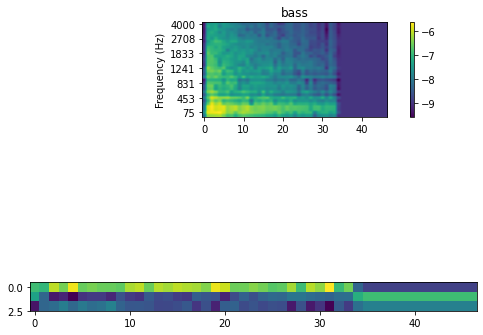

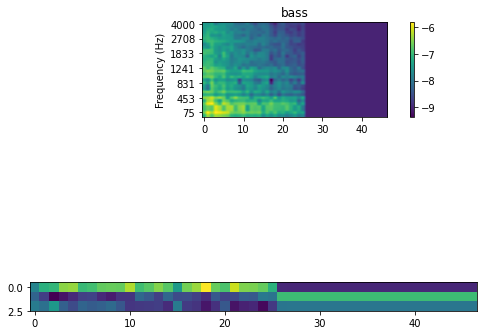

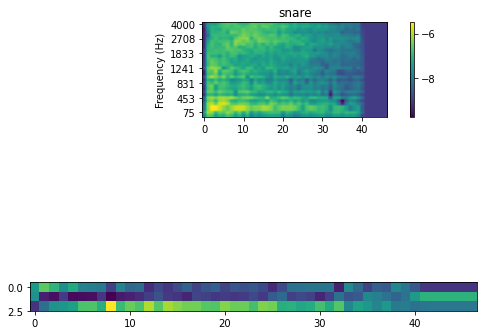

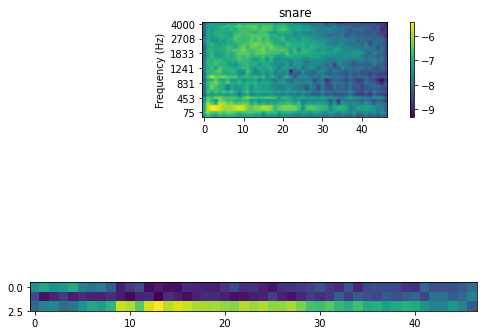

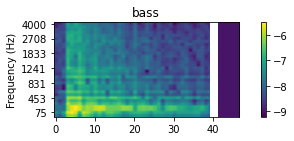

In [85]:
for idx, input_spectrogram in enumerate(test_input_spectrograms):
    fig = plt.figure(figsize=(8, 8))
    audio_ax = fig.add_subplot(4, 1, 1)
    picture = audio_ax.imshow(input_spectrogram.T[::-1])
    fig.colorbar(picture, ax=audio_ax)
    audio_ax.set_yticks(np.arange(0, N_MELS, 5))
    audio_ax.set_yticklabels([f"{int(f)}" for f in mel_freqs[::-5]])
    audio_ax.set_ylabel("Frequency (Hz)")
    audio_ax.set_aspect(0.75)
    audio_ax.set_title(audio_data[idx][1])
    
    n_steps = input_spectrogram.shape[0]
    labels = np.zeros([n_steps, N_CLASSES])
    for idx in range(n_steps):
        network(input_spectrogram[idx, :])
        labels[idx] = regressor.predict(network.x_flatten.reshape(1, -1))
    label_ax = fig.add_subplot(4, 1, 3)
    label_ax.imshow(labels.T)
    for i in range(10):
        network(np.zeros(N_MELS) - 9.)
#     label = np.argmax(labels, axis=1).mode()
#     label_ax.set_title(f"prediction: {label}")